# Cargar

## Biblioteca

In [3]:
import optuna
import pandas as pd  # load and manipulate data and for One-Hot Encoding
import numpy as np  # calculate the mean and standard deviation
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb  # XGBoost stuff
from sklearn.model_selection import train_test_split  # split data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer  # for scoring during
from sklearn.model_selection import GridSearchCV  # cross validation
from sklearn.metrics import confusion_matrix  # creates a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay  # draws a confusion matrix
from sklearn.preprocessing import OneHotEncoder  # Más explícito para encoding
from sklearn.metrics import classification_report

import time
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from itertools import product
import cupy as cp


## Data Frame

In [2]:
df_base = pd.read_csv('base_rm.csv', encoding='utf-8', low_memory=False)
df_base = df_base.reset_index(drop=True)
df_base['Date'] = pd.to_datetime(df_base['Date'])

df_base = df_base.sort_values('Date')

filas, columnas = df_base.shape
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 8177031
Número de columnas: 18


In [3]:
df_base.head()

,Date,Nombre_Oficina_Arp,Nombre_Municipio_IPS2,MUNICIPIO,Nombre_Tipo_Atencion_Arp,Cantidad,TENDENCIA,lag_1,lag_7,mm_7,mm_12,mm_30,delta_lag,std_7,Day,Month,Year,Day_Week
0,2019-01-01,OFICINA BOGOTA,MEDELLIN,BARRANQUILLA,QUIRURGICO HOSPITALARIO,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2019,1
1,2019-01-01,OFICINA BOGOTA,MEDELLIN,BOGOTA,AMBULATORIA,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2019,1
2,2019-01-01,OFICINA BOGOTA,MEDELLIN,FUNZA,QUIRURGICO HOSPITALARIO,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2019,1
3,2019-01-01,OFICINA CALI,CHIA,SANTIAGO DE CALI,UNIDAD DE CUIDADOS INTENSIVOS,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2019,1
4,2019-01-01,OFICINA CALI,MEDELLIN,PRADERA,QUIRURGICO AMBULATORIO,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2019,1


# Formato

## Encoded

In [4]:
def encoded(df_base):

    df_encoded_base = pd.get_dummies(df_base, columns=['Nombre_Oficina_Arp', 'Nombre_Tipo_Atencion_Arp'])

    lip = LabelEncoder()
    lm = LabelEncoder()

    df_encoded_base['Nombre_Municipio_IPS2'] = lip.fit_transform(df_base['Nombre_Municipio_IPS2'])
    df_encoded_base['MUNICIPIO'] = lm.fit_transform(df_base['MUNICIPIO'])

    municipio_ips_dict = dict(zip(lip.transform(lip.classes_), lip.classes_))
    municipio_dict = dict(zip(lm.transform(lm.classes_), lm.classes_))

    df_encoded_base.head()

    return df_encoded_base


In [5]:
df_encoded_base = encoded(df_base)

## Division

In [6]:
df_encoded_base.tail(1)

,Date,Nombre_Municipio_IPS2,MUNICIPIO,Cantidad,TENDENCIA,lag_1,lag_7,mm_7,mm_12,mm_30,...,Nombre_Oficina_Arp_OFICINA MANIZALES,Nombre_Oficina_Arp_OFICINA MEDELLIN,Nombre_Oficina_Arp_OFICINA PEREIRA,Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA,Nombre_Tipo_Atencion_Arp_AMBULATORIA,Nombre_Tipo_Atencion_Arp_HOSPITALARIA,Nombre_Tipo_Atencion_Arp_ODONTOLOGIA,Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS
8177030,2024-12-31 22:35:00,15,547,1,2191,1.0,1.0,1.0,1.0,NaN,...,False,True,False,False,False,False,False,False,True,False


In [7]:
df_encoded_base.dtypes

Date                                                      datetime64[ns]
Nombre_Municipio_IPS2                                              int32
MUNICIPIO                                                          int32
Cantidad                                                           int64
TENDENCIA                                                          int64
lag_1                                                            float64
lag_7                                                            float64
mm_7                                                             float64
mm_12                                                            float64
mm_30                                                            float64
delta_lag                                                        float64
std_7                                                            float64
Day                                                                int64
Month                                              

In [8]:
# Dividir datos
cutoff = pd.to_datetime('2024-12-31')
train = df_encoded_base[df_encoded_base['Date'] <= cutoff]

X_train = train.drop(columns=['Date', 'Cantidad'])
y_train = train['Cantidad']

# Optimizar tipos para X_train
X_train_opt = X_train.copy()
for col in X_train_opt.columns:
    if X_train_opt[col].dtype == 'float64':
        X_train_opt[col] = X_train_opt[col].astype('float32')
    elif X_train_opt[col].dtype == 'int32':
        X_train_opt[col] = X_train_opt[col].astype('int16')
    elif X_train_opt[col].dtype == 'bool':
        X_train_opt[col] = X_train_opt[col].astype('int8')

# Convertir a GPU (cupy)
X_train_gpu = cp.asarray(X_train_opt.to_numpy())
y_train_gpu = cp.asarray(y_train.to_numpy())

# Estructura DMatrix en GPU
dtrain = xgb.DMatrix(X_train_gpu, label=y_train_gpu)

# Verificar formas
print("X shape:", df_encoded_base.shape)
print("X_train shape:", X_train_gpu.shape)


X shape: (8177031, 31)
X_train shape: (8175418, 29)


In [9]:
X_train.dtypes

Nombre_Municipio_IPS2                                       int32
MUNICIPIO                                                   int32
TENDENCIA                                                   int64
lag_1                                                     float64
lag_7                                                     float64
mm_7                                                      float64
mm_12                                                     float64
mm_30                                                     float64
delta_lag                                                 float64
std_7                                                     float64
Day                                                         int64
Month                                                       int64
Year                                                        int64
Day_Week                                                    int64
Nombre_Oficina_Arp_OFICINA BARRANQUILLA                      bool
Nombre_Ofi

## Modelo

In [10]:
best_params = {'learning_rate': 0.13885950089105642, 
               'max_depth': 4, 
               'subsample': 0.9394067504888292, 
               'colsample_bytree': 0.6889512020025766, 
               'gamma': 3.9673344536177053, 
               'lambda': 0.023814343152790428, 
               'alpha': 1.4596890089856196, 
               'n_estimators': 192}

params = {
    'objective': 'reg:squarederror',
    'device': 'cuda',
    'learning_rate': best_params['learning_rate'],
    'max_depth': best_params['max_depth'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'lambda': best_params['lambda'],
    'alpha': best_params['alpha'],
    'eval_metric': 'rmse'
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_params['n_estimators'],  # ¡Importante!
    evals=[(dtrain, 'Train')],
    early_stopping_rounds=20,
    verbose_eval=True
)

[0]	Train-rmse:3.74224
[1]	Train-rmse:3.25319
[2]	Train-rmse:3.24721
[3]	Train-rmse:2.82851
[4]	Train-rmse:2.82180
[5]	Train-rmse:2.81666
[6]	Train-rmse:2.81292
[7]	Train-rmse:2.45723
[8]	Train-rmse:2.15301
[9]	Train-rmse:1.89467
[10]	Train-rmse:1.67739
[11]	Train-rmse:1.67492
[12]	Train-rmse:1.67168
[13]	Train-rmse:1.66956
[14]	Train-rmse:1.66824
[15]	Train-rmse:1.48518
[16]	Train-rmse:1.32990
[17]	Train-rmse:1.32893
[18]	Train-rmse:1.19997
[19]	Train-rmse:1.09499
[20]	Train-rmse:0.97845
[21]	Train-rmse:0.90417
[22]	Train-rmse:0.82909
[23]	Train-rmse:0.77883
[24]	Train-rmse:0.74021
[25]	Train-rmse:0.70973
[26]	Train-rmse:0.70562
[27]	Train-rmse:0.65280
[28]	Train-rmse:0.61040
[29]	Train-rmse:0.60741
[30]	Train-rmse:0.57263
[31]	Train-rmse:0.54429
[32]	Train-rmse:0.52111
[33]	Train-rmse:0.52032
[34]	Train-rmse:0.50864
[35]	Train-rmse:0.49170
[36]	Train-rmse:0.48571
[37]	Train-rmse:0.48264
[38]	Train-rmse:0.48019
[39]	Train-rmse:0.46643
[40]	Train-rmse:0.45272
[41]	Train-rmse:0.45095
[4

In [11]:
#df_encoded_base.to_csv('base_2.csv', index=False, encoding='utf-8-sig')

# Prediccion 

Usando autoregressive forecasting loop

In [12]:
def predecir(df_hist, model, X_columns, codificar_variables,
                                           start_date="2025-01-01", end_date="2025-12-31", n_jobs=-1):

    fechas_futuras = pd.date_range(start=start_date, end=end_date, freq="D")

    moda_municipio = (
        df_hist
        .groupby(["Nombre_Municipio_IPS2", "Nombre_Oficina_Arp", "Nombre_Tipo_Atencion_Arp"])["MUNICIPIO"]
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        .reset_index()
    )

    combinaciones = df_hist[["Nombre_Municipio_IPS2", "Nombre_Oficina_Arp", "Nombre_Tipo_Atencion_Arp"]].drop_duplicates()

    combinaciones = combinaciones.merge(moda_municipio, on=["Nombre_Municipio_IPS2", "Nombre_Oficina_Arp", "Nombre_Tipo_Atencion_Arp"], how="left")

    def predecir_una_combinacion(comb):
        muni = comb["Nombre_Municipio_IPS2"]
        municipio = comb["MUNICIPIO"]
        oficina = comb["Nombre_Oficina_Arp"]
        tipo = comb["Nombre_Tipo_Atencion_Arp"]

        df_comb = df_hist[
            (df_hist["Nombre_Municipio_IPS2"] == muni) &
            (df_hist["Nombre_Oficina_Arp"] == oficina) &
            (df_hist["Nombre_Tipo_Atencion_Arp"] == tipo)
        ].sort_values("Date")

        base = df_comb.copy()
        predicciones = []

        for fecha in fechas_futuras:
            nueva = {
                "Date": fecha,
                "Nombre_Municipio_IPS2": muni,
                "MUNICIPIO": municipio,
                "Nombre_Oficina_Arp": oficina,
                "Nombre_Tipo_Atencion_Arp": tipo,
                "lag_1": base["Cantidad"].iloc[-1] if len(base) >= 1 else 1,
                "lag_7": base["Cantidad"].iloc[-7] if len(base) >= 7 else base["Cantidad"].mean(),
                "mm_7": base["Cantidad"].iloc[-7:].mean() if len(base) >= 7 else base["Cantidad"].mean(),
                "mm_12": base["Cantidad"].iloc[-12:].mean() if len(base) >= 12 else base["Cantidad"].mean(),
                "mm_30": base["Cantidad"].iloc[-30:].mean() if len(base) >= 30 else base["Cantidad"].mean(),
                "std_7": base["Cantidad"].iloc[-7:].std() if len(base) >= 7 else base["Cantidad"].std(),
                "month": fecha.month,
                "weekday": fecha.weekday()
            }
        
            df_pred = pd.DataFrame([nueva])
            df_pred = codificar_variables(df_pred)  # <- codificación aquí
            df_pred = df_pred.reindex(columns=X_columns, fill_value=0)  # asegurar orden
            
            for col in df_pred.columns:
                if df_pred[col].dtype == 'float64':
                    df_pred[col] = df_pred[col].astype('float32')
                elif df_pred[col].dtype == 'int32':
                    df_pred[col] = df_pred[col].astype('int16')
                elif df_pred[col].dtype == 'bool':
                    df_pred[col] = df_pred[col].astype('int8')

            df_pred = df_pred.fillna(0)
            
            try:
                dpred = xgb.DMatrix(df_pred)  
                y_pred = model.predict(dpred)[0]
            except:
                y_pred = 0  # o usa np.nan si prefieres

            nueva["Cantidad"] = y_pred
            predicciones.append(nueva)
            base = pd.concat([base, pd.DataFrame([nueva])], ignore_index=True)

        return predicciones

    # Ejecutar en paralelo
    resultados = Parallel(n_jobs=n_jobs)(
        delayed(predecir_una_combinacion)(comb)
        for _, comb in tqdm(combinaciones.iterrows(), total=combinaciones.shape[0])    
    )

    # Aplanar la lista de listas
    df_resultado = pd.DataFrame([fila for grupo in resultados for fila in grupo])

    return df_resultado

In [13]:
print(X_train_opt.columns.tolist())

['Nombre_Municipio_IPS2', 'MUNICIPIO', 'TENDENCIA', 'lag_1', 'lag_7', 'mm_7', 'mm_12', 'mm_30', 'delta_lag', 'std_7', 'Day', 'Month', 'Year', 'Day_Week', 'Nombre_Oficina_Arp_OFICINA BARRANQUILLA', 'Nombre_Oficina_Arp_OFICINA BOGOTA', 'Nombre_Oficina_Arp_OFICINA BUCARAMANGA', 'Nombre_Oficina_Arp_OFICINA CALI', 'Nombre_Oficina_Arp_OFICINA CARTAGENA', 'Nombre_Oficina_Arp_OFICINA MANIZALES', 'Nombre_Oficina_Arp_OFICINA MEDELLIN', 'Nombre_Oficina_Arp_OFICINA PEREIRA', 'Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA', 'Nombre_Tipo_Atencion_Arp_AMBULATORIA', 'Nombre_Tipo_Atencion_Arp_HOSPITALARIA', 'Nombre_Tipo_Atencion_Arp_ODONTOLOGIA', 'Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO', 'Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO', 'Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS']


In [14]:
start = time.time()

df_pred_auto = predecir(
    df_hist=df_base, 
    model=model, 
    X_columns=X_train_opt.columns.tolist(), 
    codificar_variables=encoded, 
    n_jobs = 17)

end = time.time()
print(f"Tiempo total de predicción: {round(end - start, 2)} segundos")

100%|██████████| 4056/4056 [2:01:04<00:00,  1.79s/it]  


Tiempo total de predicción: 7349.2 segundos


## Resultados

In [16]:
filas, columnas = df_pred_auto.shape
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 1480440
Número de columnas: 14


In [17]:
df_pred_auto.head()

,Date,Nombre_Municipio_IPS2,MUNICIPIO,Nombre_Oficina_Arp,Nombre_Tipo_Atencion_Arp,lag_1,lag_7,mm_7,mm_12,mm_30,std_7,month,weekday,Cantidad
0,2025-01-01,MEDELLIN,BOGOTA,OFICINA BOGOTA,QUIRURGICO HOSPITALARIO,1.000000,1.0,1.142857,1.083333,1.433333,0.377964,1,2,1.004598
1,2025-01-02,MEDELLIN,BOGOTA,OFICINA BOGOTA,QUIRURGICO HOSPITALARIO,1.004598,2.0,1.143514,1.083717,1.433487,0.377679,1,3,0.936159
2,2025-01-03,MEDELLIN,BOGOTA,OFICINA BOGOTA,QUIRURGICO HOSPITALARIO,0.936159,1.0,0.991537,1.078396,1.398025,0.024479,1,4,1.020025
3,2025-01-04,MEDELLIN,BOGOTA,OFICINA BOGOTA,QUIRURGICO HOSPITALARIO,1.020025,1.0,0.994397,1.080065,1.398693,0.026702,1,5,1.020025
4,2025-01-05,MEDELLIN,BOGOTA,OFICINA BOGOTA,QUIRURGICO HOSPITALARIO,1.020025,1.0,0.997258,1.081734,1.399360,0.028420,1,6,1.020025


In [ ]:
#df_pred_auto.to_csv('prediccion_.csv', index=False, encoding='utf-8')

In [4]:
df_pred_auto = pd.read_csv('prediccion_.csv', encoding='utf-8', low_memory=False)

In [5]:
Atencion = Atencion = df_pred_auto['Nombre_Tipo_Atencion_Arp'].value_counts().reset_index()
Atencion.columns = ['Nombre_Tipo_Atencion_Arp', 'Frecuencia']

print(Atencion)

        Nombre_Tipo_Atencion_Arp  Frecuencia
0                    AMBULATORIA      368650
1        QUIRURGICO HOSPITALARIO      284700
2         QUIRURGICO AMBULATORIO      263530
3                   HOSPITALARIA      195640
4  UNIDAD DE CUIDADOS INTENSIVOS      170455
5                    ODONTOLOGIA      105120
6                 ALTA INMEDIATA       92345


In [8]:
Municipio_IPS = df_pred_auto['Nombre_Municipio_IPS2'].value_counts().reset_index()
Municipio_IPS.columns = ['Nombre_Municipio_IPS2', 'Frecuencia']

print(Municipio_IPS)

    Nombre_Municipio_IPS2  Frecuencia
0                MEDELLIN       20440
1                 PEREIRA       20440
2                  BOGOTA       20440
3            BARRANQUILLA       20075
4        SANTIAGO DE CALI       20075
..                    ...         ...
158     OFICINA MANIZALES        2555
159          OFICINA CALI        2555
160  OFICINA BARRANQUILLA        2555
161   OFICINA BUCARAMANGA        2555
162     OFICINA CARTAGENA        2190

[163 rows x 2 columns]


## Grafica

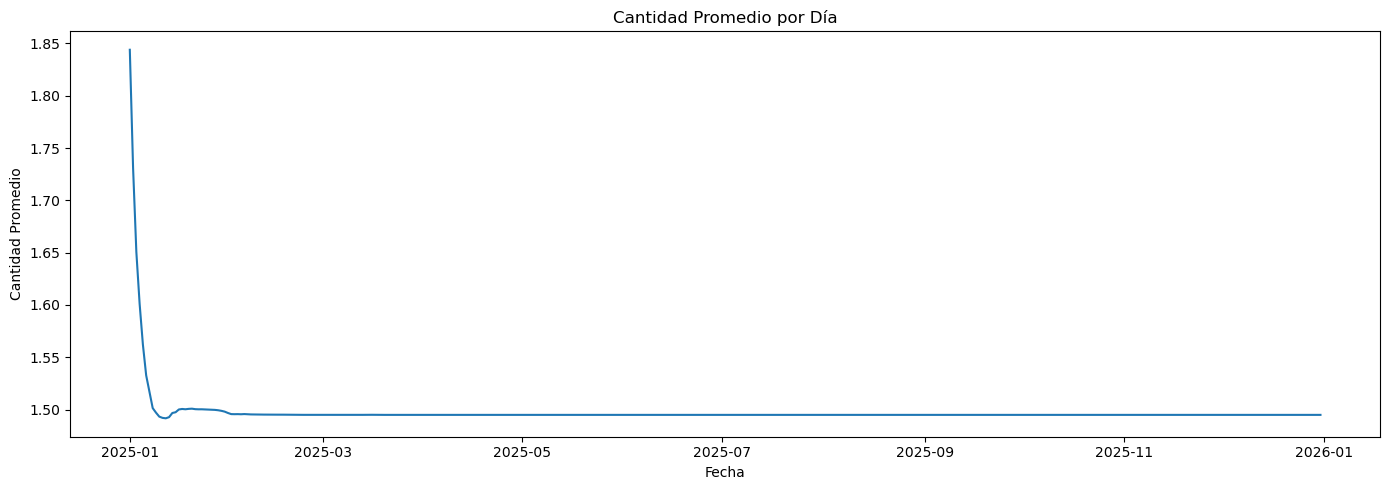

In [21]:
# Asegurar tipo datetime
df_pred_auto['Date'] = pd.to_datetime(df_pred_auto['Date'])

# Agrupar por fecha
media_diaria = df_pred_auto.groupby('Date')['Cantidad'].mean().reset_index()

# Gráfico
plt.figure(figsize=(14, 5))
sns.lineplot(data=media_diaria, x='Date', y='Cantidad')
plt.title('Cantidad Promedio por Día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Promedio')
plt.tight_layout()
plt.show()

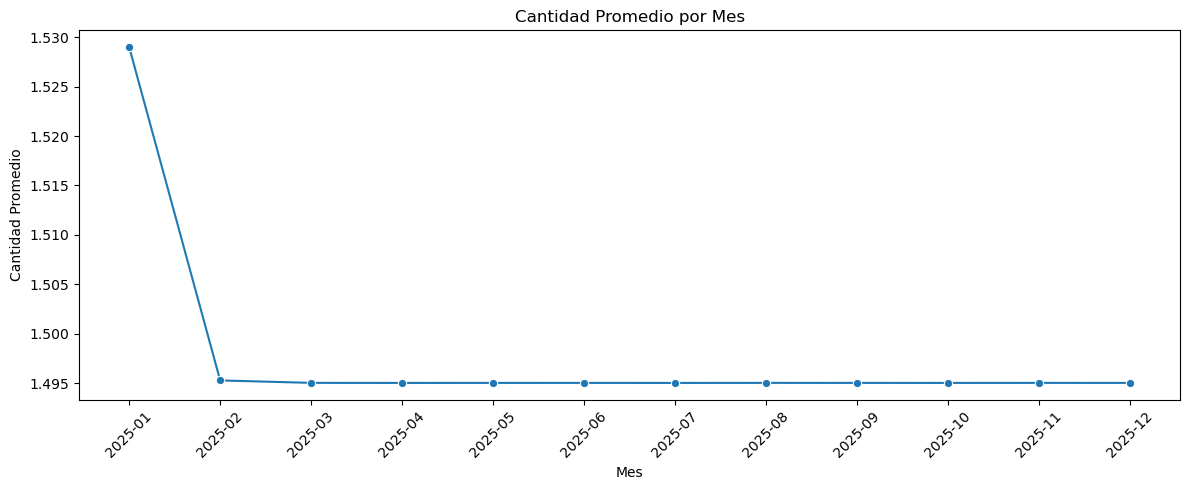

In [22]:
# Asegurar que la columna de fecha es datetime
df_pred_auto['Date'] = pd.to_datetime(df_pred_auto['Date'])

# Crear columna año-mes
df_pred_auto['AñoMes'] = df_pred_auto['Date'].dt.to_period('M')

# Agrupar y calcular la media mensual
media_mensual = df_pred_auto.groupby('AñoMes')['Cantidad'].mean().reset_index()
media_mensual['AñoMes'] = media_mensual['AñoMes'].astype(str)

# Gráfico
plt.figure(figsize=(12, 5))
sns.lineplot(data=media_mensual, x='AñoMes', y='Cantidad', marker='o')
plt.title('Cantidad Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
